# Part 4. Matrix and Vector Computations
## Step 13
After reading about Broadcasting with Arrays on the Chapter _Computation on Arrays: Broadcasting_ from **Python Data Science Handbook** (J. VandePlas, 2016): https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html I obtained the following information:

The text talks about the concept of broadcasting in NumPy, a powerful feature that allows for vectorized operations across arrays of different shapes without the need for explicit replication of data. Broadcasting simplifies code and enhances performance by enabling binary operations like addition, subtraction, multiplication, etc., to be efficiently executed between arrays of different sizes.

Broadcasting includes rules, for example, NumPY follows a set of rules to determine how operations between mismatched shapes are handled. It first pads the shape of the smaller array with ones on its leading side, then stretches dimensions of size 1 to match the corresponding dimensions of the other array. If mismatched sizes are found and neither is 1, an error is raised. It also avoids the explicit data duplication that would be necessary for operations between arrays of different shapes, leading to memory and computational efficiency. This is crucial for high-performance computing where resources and computation time are critical. These rules apply to any binary universal functions (ufuncs) in NumPy, not just addition or multiplication, making it a versatile tool for a wide range of mathematical operations. In the text there are showed various examples, including adding a scalar to an array, adding a one-dimensional array to a two-dimensional one, and more complex cases. These examples demonstrate how broadcasting supports operations like centering an array by subtracting the mean or computing functions over a grid, which are common in data processing, scientific computing, and machine learning.

In the context of High Performance Computing (HPC) and matrix/vector computations, broadcasting is useful because it allows for the efficient execution of vectorized operations, which are key to achieving high performance in numerical computations. This efficiency is due to the avoidance of explicit loops in Python, leveraging instead the optimized implementations of these operations in lower-level languages. It also simplifies the code for matrix and vector operations, making it easier to read, write, and maintain. Additionally, the ability to perform operations on arrays of different shapes and sizes without explicit reshaping or resizing is a significant advantage, because it offers flexibility in designing algorithms and implementing mathematical models.

## Step 14
After reading _Rewriting the particle simulator in NumPy_ on **_Chapter 3: Fast Array Operations with NumPy and Pandas (pp. 68)_** from the book **G. Lenaro (2017). Python High Performance. Second Edition. UK: Packt Publishing Ltd.** I will implement the improvements on the particle simulator using NumPy and show that both implementations scale linearly with particle size, but the runtime in the pure Python version grows much faster than the NumPy version.

The `evolve_pytho` method of the `ParticleSimulator` class uses pure Python loops and arithmetic operations to compute the evolution of particles over time. It calculates the norm and the velocity components for each particle individually within a nested loop structure. This can be computationally inefficient due to Python's inherent overhead in looping and handling individual arithmetic operations in the interpreted runtime environment. On the other hand, the `evolve_numpy` method takes advantage of NumPy's array operations. This allows the method to compute the norms and velocity components for all particles at once. The operations are applied to whole arrays of data in parallel, making use of lower-level optimizations and potentially faster CPU instructions.

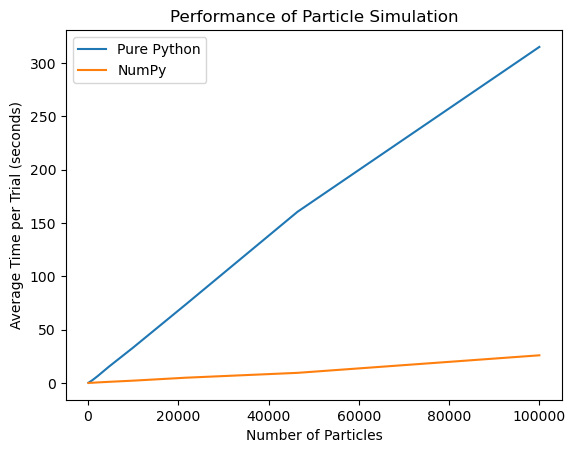

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import timeit
from random import uniform
import numpy as np
from ParticleSim import Particle, ParticleSimulator

def benchmark(npart=100, method='python'):
    particles = [Particle(uniform(-1.0, 1.0),
                          uniform(-1.0, 1.0),
                          uniform(-1.0, 1.0))
                 for i in range(npart)]
    
    simulator = ParticleSimulator(particles)
    
    if method == 'python':
        simulator.evolve_python(0.1)
    elif method == 'numpy':
        simulator.evolve_numpy(0.1)

# Benchmark function
def run_benchmarks(particle_sizes, trials=3):
    python_times = []
    numpy_times = []
    
    for size in particle_sizes:
        # Use a lambda to define the size within the timeit scope
        python_time = timeit(lambda: benchmark(size, method="python"), number=trials)
        numpy_time = timeit(lambda: benchmark(size, method="numpy"), number=trials)
        
        python_times.append(python_time / trials)
        numpy_times.append(numpy_time / trials)
        
    return python_times, numpy_times


# Range of particle sizes to test
# Range of particle sizes to test, increasing in logarithmic scale
particle_sizes = np.logspace(2, 5, num=10, dtype=int)

# Run benchmarks
python_times, numpy_times = run_benchmarks(particle_sizes)

# Plotting
plt.plot(particle_sizes, python_times, label='Pure Python')
plt.plot(particle_sizes, numpy_times, label='NumPy')
plt.xlabel('Number of Particles')
plt.ylabel('Average Time per Trial (seconds)')
plt.title('Performance of Particle Simulation')
plt.legend()
plt.show()

The graph illustrates the comparative performance of the two particle simulation methods as the number of particles increases. The execution time for both methods rises in direct proportion to the number of particles, which indicates that the complexity of both algorithms is linear, each additional particle seems to add a roughly constant amount of time to the simulation. However, the pure Python version's execution time increases at a much steeper rate than that of the NumPy version. This demonstrates the higher efficiency of NumPy for numerical computations, especially as the number of particles grows. With a larger dataset, NumPy's advantage becomes more pronounced, emphasizing its ability to handle extensive numerical operations more effectively.

## Step 15
Now, I'll explain how to obtain the optimal performance with `numexpr`. To do this, first, I read the section _Reaching optimal performance with numexpr, pp. 72_. I will implement it and measure the execution time.

The usage of `numexpr` is generally straightforward and based on a single function: `numexpr.evaluate`. For example, we will calculate a simple `a + b * c` expression:

In [2]:
import numexpr as ne
import numpy as np

a = np.random.rand(10000)
b = np.random.rand(10000)
c = np.random.rand(10000)
d = ne.evaluate('a + b * c')

Now, I will measure the time it takes to calculate d:

In [3]:
%timeit -n 1 -r 3 ne.evaluate('a + b * c')

359 µs ± 45.6 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


The `numexp` package increases the performances in almost all cases, but to get a substantial advantage, you should use it with large arrays. For example, an application that involves a large array is
the calculation of a distance matrix. In a particle system, a distance matrix contains all the possible distances between the particles. To calculate it, we should first calculate all the vectors connecting any two particles (i,j). Then, we calculate the length of this vector by taking its norm. We can write this in NumPy by employing the usual broadcasting rules:

In [4]:
def numpy_distance_matrix(r):
    r_i = r[:, np.newaxis]
    r_j = r[np.newaxis, :]
    d_ij = np.sqrt(((r_i - r_j) ** 2).sum(axis=2))
    return d_ij

# Example usage with random points
r = np.random.rand(10000, 2)
%timeit -n 1 -r 3 numpy_distance_matrix(r)

2.81 s ± 76.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


To compare, we can write the same expression using the`ǹumexpr` syntax:

In [6]:
def numexpr_distance_matrix(r):
    r_i = r[:, np.newaxis]
    r_j = r[np.newaxis, :]
    
    d_ij = ne.evaluate('sum((r_j - r_i)**2, 2)')
    d_ij = ne.evaluate('sqrt(d_ij)')
    return d_ij

# Example usage with random points
r = np.random.rand(10000, 2)
%timeit -n 1 -r 3 numexpr_distance_matrix(r)

841 ms ± 31.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Now, I'll compare performance:

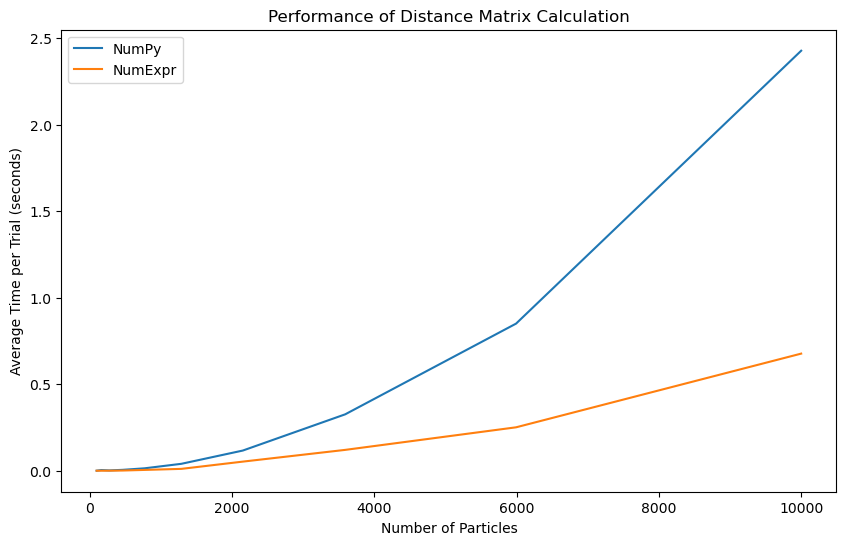

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numexpr as ne
from timeit import timeit

def benchmark_distance_matrix(npart=100, method='numpy'):
    r = np.random.rand(npart, 2)
    
    if method == 'numpy':
        return numpy_distance_matrix(r)
    elif method == 'numexpr':
        return numexpr_distance_matrix(r)

# Benchmark function
def run_benchmarks_distance_matrix(particle_sizes, trials=3):
    numpy_times = []
    numexpr_times = []
    
    for size in particle_sizes:
        numpy_time = timeit(lambda: benchmark_distance_matrix(size, method="numpy"), number=trials)
        numexpr_time = timeit(lambda: benchmark_distance_matrix(size, method="numexpr"), number=trials)
        
        numpy_times.append(numpy_time / trials)
        numexpr_times.append(numexpr_time / trials)
        
    return numpy_times, numexpr_times

# Range of particle sizes to test, increasing in logarithmic scale
particle_sizes = np.logspace(2, 4, num=10, dtype=int)

# Run benchmarks
numpy_times, numexpr_times = run_benchmarks_distance_matrix(particle_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(particle_sizes, numpy_times, label='NumPy')
plt.plot(particle_sizes, numexpr_times, label='NumExpr')
plt.xlabel('Number of Particles')
plt.ylabel('Average Time per Trial (seconds)')
plt.title('Performance of Distance Matrix Calculation')
plt.legend()
plt.show()

After this implementation, it can be seen that using the `numexpr` package improves performance. This enhancement occurs because of `numexpr`'s ability to optimize array expressions dynamically, minimizing memory allocation for intermediate results and efficiently utilizing CPU cache. Additionally, `numexpr` leverages multiple processors, distributing computations to execute in parallel. 

The key to achieving optimal performance with `numexpr` lies in its application to large arrays and complex expressions. By packing as much of the computation as possible into single `numexpr.evaluate` calls, you reduce the overhead of Python's interpretation cycle and make full use of `numexpr`'s optimizations.

## Conclusion
The integration of NumPy and NumExpr into numerical computations represents a powerful strategy for enhancing performance. NumPy's broadcasting facilitates the efficient manipulation of arrays, while NumExpr's optimized expression evaluation further accelerates computation. These tools can offer optimal performance in Python's numerical and array-based operations, making them indispensable for applications requiring high efficiency and scalability.